In [1]:
import numpy as np
import pandas as pd
import time
from collections import namedtuple

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL.rl_modules.sac_agent import *

from REACTRL import DissociateEnv, RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory, ddpg_agent
from scipy.spatial import distance
from REACTRL.task_script.utils import *

np.random.seed(2)  # reproducible

c:\Users\wun2\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\wun2\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\wun2\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


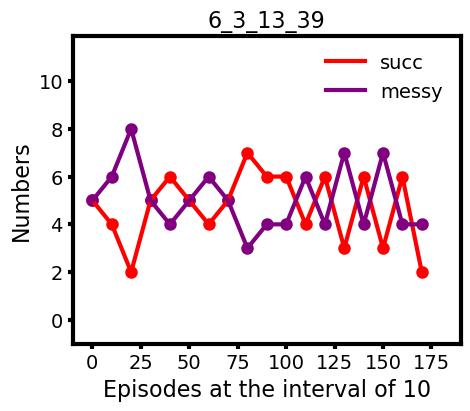

In [3]:
# label_episode=pd.read_csv('voltage_current_5_31_22_48_episode.csv', sep='\t')
# label_middle=pd.read_csv('voltage_current_5_31_22_48_middle.csv', sep='\t')

# label_episode, label_middle=performance_model_succ_rate(current_time='5_20_11_4')
# label_episode, label_middle=performance_model_succ_rate(current_time='6_3_13_39')

In [20]:
label_episode

Unnamed: 0  episode_i  diss_i  done_diss  tip_x  tip_y  mvoltage  \
0             0          0       5      False   0.69   0.26   1723.85   
1             1          1       0       True   0.39   0.53   3828.46   
2             2          2       0       True   0.38   0.63   3032.61   
3             3          3       6      False   0.37  -0.66   3699.17   
4             4          4       9      False   0.40  -0.70   3678.97   
..          ...        ...     ...        ...    ...    ...       ...   
151         151        155       0       True   0.56   0.21   3882.70   
152         152        156       2       True   0.70  -0.05   3684.53   
153         153        157       1       True   0.70   0.13   3876.47   
154         154        158       0      False   0.33  -0.57   2975.13   
155         155        159       0       True   0.62   0.12   2807.53   

     pcurrent  expert  tip_dist  
0      812.93     3.0  0.737360  
1      653.87     3.0  0.658027  
2      782.68     1.0  0.735731  
3     1127.05     3.0  0.756637  
4     1063.79     3.0  0.806226  
..        ...     ...       ...  
151    397.90     3.0  0.598080  
152   1114.98     3.0  0.701783  
153    544.67     3.0  0.711969  
154    655.11     3.0  0.658635  
155   1022.76     1.0  0.631506  

[156 rows x 10 columns]

In [2]:
label_episode=pd.read_csv('label_episode_5_31_22_48_expert_64_87.csv')
label_middle=pd.read_csv('label_middle_5_31_22_48_expert_433.csv')
label_episode['mvoltage']=label_episode['mvoltage']/4000
label_middle['mvoltage']=label_middle['mvoltage']/4000
label_episode['pcurrent']=label_episode['pcurrent']/1200
label_middle['pcurrent']=label_middle['pcurrent']/1200

In [3]:
class env_toy:
    def __init__(self):
        self.state = [1]

    def reset(self):
        state = self.state
        info={'state':self.state}
        self.img_info = info
        return state, info
    
    def step(self, action, step_i=0):

        reward, pred_prod=self.compute_reward(action, step_i=step_i)

        if pred_prod == 0:
            done_diss = True
            done_messy = False
            next_state = [0]
        elif pred_prod == 1:
            done_diss = False
            done_messy = True
            next_state = [2]
        else:
            done_diss = False
            done_messy = False
            next_state = [1]
        info={'state':self.state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done_diss}
        return next_state, reward, done_diss, done_messy, info

    def compute_reward(self, action, step_i=0):
        ref_point=np.array([action])
        # succ=label_episode[label_episode['done_diss']==True][['mvoltage', 'pcurrent']].to_numpy()
        # mess=label_episode[label_episode['done_diss']==False][['mvoltage', 'pcurrent']].to_numpy()
        # succ=label_episode[label_episode['done_diss']=='True'][['mvoltage', 'pcurrent']].to_numpy()
        # mess=label_episode[label_episode['done_diss']=='False'][['mvoltage', 'pcurrent']].to_numpy()
        succ=label_episode[label_episode['expert']==1][['mvoltage', 'pcurrent']].to_numpy()
        mess=label_episode[label_episode['expert']==3][['mvoltage', 'pcurrent']].to_numpy()
        rotation=label_middle[['mvoltage', 'pcurrent']].to_numpy()
        dist_succ=distance.cdist(ref_point, succ, 'euclidean')
        dist_mess=distance.cdist(ref_point, mess, 'euclidean')
        dist_rotation=distance.cdist(ref_point, rotation, 'euclidean')
        pred_prod=np.argmin([dist_succ.min(), dist_mess.min(), dist_rotation.min()])

        if pred_prod==0:
            reward=1
        elif pred_prod==1:
            reward=-1
        else:
            reward= -0.2

        # if np.argmin([dist_succ.min(), dist_mess.min(), dist_rotation.min()])==0:
        #     reward=1-0.2*step_i
        # elif np.argmin([dist_succ.min(), dist_mess.min(), dist_rotation.min()])==1:
        #     reward=-1
        # else:
        #     reward=-0.2-0.2*step_i     

        # if pred_prod==0:
        #     reward=1*0.90**step_i
        # elif pred_prod==1:
        #     reward=-1/(0.95)**step_i*0.6+0.5   
        # else:
        #     pred_prod=2
        #     reward=0.05-1.02**step_i*0.003 - 0.05             

#         value_1=1*0.90**times
# value_2=0.05*0.85**times
# value_3=-0.7/(0.92**times)+0.3        
            
            
        return reward, pred_prod





In [4]:

env_toy = env_toy()
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env_toy, strategy = 'final')


episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
# folder_name =  'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/test_nian_ddpg_new_1208'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)


c_k_min = 500
eta = 0.994
max_ep_len = 5

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#TODO
# LEARNING_RATE = 0.001  # default 0.0003
# gamma = 0.9     # default 0.9
# tau = 0.1       # default 0.005
# batch_size= 64 # Set minibatch size default 64

LEARNING_RATE = 0.001  # default 0.0003
gamma = 0.99     # default 0.9
tau = 0.05       # default 0.005
batch_size= 64 # Set minibatch size default 64
 
# batch_size= 64 # 128 #Set minibatch size
# LEARNING_RATE = 0.0003 #Set learning rate
 
#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
# action_space = ACTION_SPACE(high = torch.tensor([1, 1, 1, 1]), low = torch.tensor([-1, -1, 0.25, 0.0]))  # 4 D
 
action_space = ACTION_SPACE(high = torch.tensor([1, 1]), low = torch.tensor([0.25, 0.0]))
# action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1]), low = torch.tensor([-1,-1,1/3,1/2]))
# action_space = None
 
#Initialize the soft actor-critic agent
alpha = 1.0
add_step_i=True
 
# if add_step_i:
#     agent = sac_agent(num_inputs = 517, num_actions = 2, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
#                   gamma=gamma, tau=tau, alpha=alpha)  # previous is always 0.9
# else:
#     agent = sac_agent(num_inputs = 516, num_actions = 2, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
#                   gamma=gamma, tau=tau, alpha=alpha)  # previous is always 0.9
   
agent = sac_agent(num_inputs = 1, num_actions = 2, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE, gamma=gamma, tau=tau, alpha=alpha)


# agent = ddpg_agent(num_inputs = 1, num_actions = 2, device=device, hidden_size=256, lr=LEARNING_RATE,gamma=gamma, tau=tau)



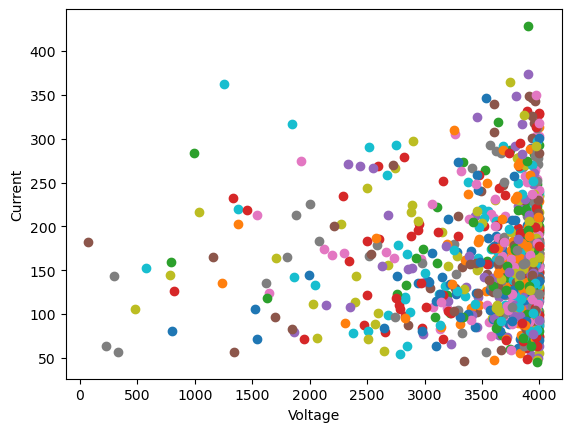

In [ ]:
for i in range(1000):
    with torch.no_grad():
        voltage, current=agent.select_action(state)
        plt.scatter(voltage*4000, current*1200)
    plt.xlabel('Voltage')
    plt.ylabel('Current')




In [19]:
episode_start=0
num_episodes=10000
max_steps=100
batch_size=128
c_k = 500
done_num=0
folder_name = 'sac_test_succ_expert_%s_%s_%s' % (LEARNING_RATE, gamma, tau)
os.makedirs(folder_name, exist_ok=True)
torch.manual_seed(19)
eps=0.05
var=0.01

for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done_diss = False
    state, info = env_toy.reset()

    episode_memory.update_memory_reset(env_toy.img_info, i_episode, info)
    step=0
    while not done_diss:
          # epsilon greedy 
        # p = np.random.random() 
        # if p < eps and done_num<10: 
        #    action = np.random.random(2)
        # else: 
        action = agent.select_action(state)
        #    action = np.clip(np.random.normal(action, var), 0, 1) 

        next_state, reward, done_diss, done_messy, info = env_toy.step(action, step_i=step)
        step+=1
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done_diss)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done_diss, info)

        print('i_episode:', i_episode, 'step:', step, 'state:', state, 'action:', action, 'reward:', reward, 'done:', done_diss)

        # with open('%s/sac_test_succ.txt' % folder_name, 'a') as f:
        #     f.write('i_episode: {}, step: {}, state: {}, action: {}, reward: {}, done: {}\n'.format(i_episode, step, state, action, reward, done_diss))
        with open('%s/sac_action.txt' % folder_name, 'a') as f:
            f.write('mvoltage: {}, pcurrent: {}\n'.format(action[0], action[1]))


        if (len(memory)>batch_size) and done_num>0:
            agent.update_parameters(memory, batch_size, c_k)

        if done_diss:
            done_num=done_num+1                
        
        if done_diss or done_messy:
            break




    with open('%s/sac_reward.txt' % folder_name, 'a') as f:
        f.write('episode_reward: {}, episode_steps: {}\n'.format(episode_reward, episode_steps))
    

    

        
    # if (i_episode)%500 == 0:
    #     torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
    #     torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
    #     torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))

Episode: 0
i_episode: 0 step: 1 state: [1] action: [0.6214793  0.40421498] reward: -0.2 done: False
i_episode: 0 step: 2 state: [1] action: [0.53221416 0.0173499 ] reward: -0.4 done: False
i_episode: 0 step: 3 state: [1] action: [0.8753445  0.00521758] reward: -0.6000000000000001 done: False
i_episode: 0 step: 4 state: [1] action: [0.7912365 0.9877697] reward: -0.8 done: False
i_episode: 0 step: 5 state: [1] action: [0.34960717 0.04879832] reward: -1.0 done: False
i_episode: 0 step: 6 state: [1] action: [0.7032187 0.898342 ] reward: -1.2 done: False
i_episode: 0 step: 7 state: [1] action: [0.5118142 0.8857419] reward: -1.4000000000000001 done: False
i_episode: 0 step: 8 state: [1] action: [0.83242553 0.32591408] reward: -1.6 done: False
i_episode: 0 step: 9 state: [1] action: [0.26142293 0.41115615] reward: -1.8 done: False
i_episode: 0 step: 10 state: [1] action: [0.31830922 0.18628696] reward: -2.0 done: False
i_episode: 0 step: 11 state: [1] action: [0.63840544 0.04328048] reward: -

KeyboardInterrupt: 